# Boundary conditions on a cylindrical geometry

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline

from tyssue.core.sheet import Sheet

from tyssue import config

from tyssue.geometry.sheet_geometry import SheetGeometry as geom
from tyssue.solvers.sheet_vertex_solver import Solver as solver
from tyssue.dynamics.sheet_vertex_model import SheetModel as model


from tyssue.draw.vispy_draw import vp_view

from tyssue.draw.plt_draw import sheet_view
from tyssue.stores import load_datasets

from tyssue.topology.sheet_topology import remove_face
from tyssue.core.objects import get_opposite
from tyssue.core.generation import create_anchors

In [2]:
ls

Apoptosis.ipynb            Cell Division.ipynb        small_hexagonal.hf5
Boundary conditions.ipynb  Energy minimization.ipynb  Type 1 transition.ipynb


In [3]:
# h5store = 'before_apoptosis.hf5'
h5store = 'small_hexagonal.hf5'

datasets = load_datasets(h5store,
                         data_names=['face', 'vert', 'edge'])
datasets['edge'] = datasets['edge'][['srce', 'trgt', 'face']]
datasets['face'] = datasets['face'][['x', 'y', 'z', 'is_alive']]
datasets['vert'] = datasets['vert'][['x', 'y', 'z']]

specs = config.geometry.sheet_spec()
sheet = Sheet('emin', datasets, specs)
geom.update_all(sheet)

live_edges = sheet.upcast_face(sheet.face_df.is_alive)

# ## Boundary conditions
sheet.vert_df.is_active = 1


# ## Remove dead cells at boundary
boundary_cells = sheet.face_df[sheet.face_df.is_alive==0].index
for cell in boundary_cells:
    remove_face(sheet, cell)

sheet.edge_df['opposite'] = get_opposite(sheet.edge_df)


create_anchors(sheet)
anchor_elasticity = 0.3

nondim_specs = config.dynamics.quasistatic_sheet_spec_anchors()
nondim_specs['edge']['anchor_elasticity'] = anchor_elasticity
dim_model_specs = model.dimentionalize(nondim_specs)
sheet.update_specs(dim_model_specs, reset=True)

geom.update_all(sheet)

In [10]:
vp_view(sheet, ['z', 'x', 'y'])

In [9]:

min_settings = {
    'minimize': {
        'options': {
            'disp': False,
            'ftol': 1e-6,    
            'gtol': 1e-8},
        }
    }

res = solver.find_energy_min(sheet, geom, 
                             model, **min_settings)
print(res['success'])

True


In [7]:
from tyssue.draw import plt_draw

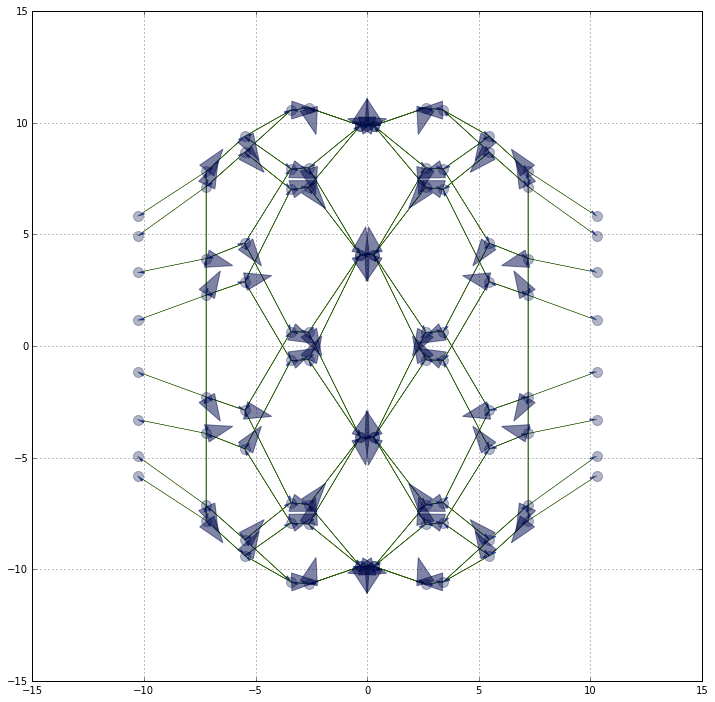

In [8]:

fig, ax = plt_draw.plot_forces(sheet, geom, model, coords=['z', 'x'], scaling=10)
fig.set_size_inches(12, 12)

In [10]:
vp_view(sheet)

/home/guillaume/anaconda3/envs/py35/lib/python3.5/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
